In [1]:
import os
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [2]:
features = "mfcc_20_no_pitch_rand"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)

for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")

reader: 1069 | # samples 300
reader: 19 | # samples 300
reader: 201 | # samples 300
reader: 250 | # samples 300
reader: 254 | # samples 300
reader: 26 | # samples 300
reader: 27 | # samples 300
reader: 289 | # samples 300
reader: 298 | # samples 300
reader: 311 | # samples 300
reader: 32 | # samples 300
reader: 3240 | # samples 300
reader: 39 | # samples 300
reader: 40 | # samples 300
reader: 4297 | # samples 300
reader: 60 | # samples 300
reader: 78 | # samples 300
reader: 7800 | # samples 300
reader: 83 | # samples 300
reader: 87 | # samples 300


In [3]:
def partition_data(reader, max, split=.8):
    mfccs = [mfcc for mfcc in reader]
    mfccs = mfccs[0:max]

    mfccs_train = mfccs[0:round(len(mfccs)*split)]
    mfccs_test  = mfccs[round(len(mfccs)*split):len(mfccs)]

    return mfccs_train, mfccs_test

def partition_wrapper(data_dictionary, max):
    test_dict = {}
    train_dict = {}

    for key in data_dictionary.keys():
        train, test = partition_data(data_dictionary[key], max)
        train_dict[key] = train
        test_dict[key] = test

    return train_dict, test_dict 

In [4]:
def generate_random_indices(n, x, seed=42):
    if n > x + 1:
        raise ValueError("Cannot generate more unique numbers than the specified range.")
    
    random.seed(seed)  # Set the seed for reproducibility
    return random.sample(range(0, x), n)

def average_score(model,test_data):
    scores = []
    for data_point in test_data:
        scores.append(model.score(data_point.reshape(1,-1)))
    return scores, np.mean(scores)

def average_score_compare(model_dict, test_data_dict):
    for model_key in model_dict.keys():
        score_list = []
        for data_key in test_data_dict.keys():
            _, avg_score = average_score(model_dict[model_key], test_data_dict[data_key])
            avg_score = round(float(avg_score), 3)
            score_list.append((data_key, avg_score))
        print(f"model {model_key}: {score_list}")

def generate_binary_test_set(data_dict, key):
    if key not in data_dict:
        raise KeyError(f"The key '{key}' does not exist in the dictionary.")
    
    true_values = data_dict[key] # Get the list corresponding to the key

    num_other_classes = len(data_dict.keys()) - 1
    num_of_true_samples = len(true_values)

    samples_per_class = num_of_true_samples // num_other_classes
    # print(f"samples per class: {samples_per_class}")

    random_indices = generate_random_indices(samples_per_class, num_of_true_samples)

    test_set = true_values.copy()  # Start with the list for the specified key
    
    for k, v in data_dict.items():
        if k != key:  # Skip the list that corresponds to the key
            for i in random_indices:
                test_set.append(v[i])

    return test_set, num_of_true_samples

def generate_metrics(model_dict, data_dict, key):
    """
    Returns:
    - [TP, FP
       FN, TN].
    """
    
    model = model_dict[key]
    control_data  = data_dict[key]
    _, threshold = average_score(model, control_data)

    data, segments_length = generate_binary_test_set(data_dict, key)

    ground_truth = [0] * segments_length + [1] * (len(data)-segments_length)
    
    scores = []
    predicted_labels = []
    for data_point in data:
        score = model.score(data_point.reshape(1,-1))
        predicted_label = 0 if score >= threshold else 1
        predicted_labels.append(predicted_label)
        scores.append(-score) 

    matrix = confusion_matrix(ground_truth, predicted_labels)
    accuracy = accuracy_score(ground_truth, predicted_labels)
    precision = precision_score(ground_truth, predicted_labels)
    recall = recall_score(ground_truth, predicted_labels)
    f1 = f1_score(ground_truth, predicted_labels)
    roc_auc = roc_auc_score(ground_truth, scores)
    fpr, tpr, _ = roc_curve(ground_truth, scores)

    return threshold, matrix, accuracy, precision, recall, f1, roc_auc, fpr, tpr

def save_metrics(model_dict, data_dict, output_file="./metrics.txt"):
    metric_dict = {}
    
    for key in model_dict.keys():
        threshold, matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)

        if isinstance(matrix, np.ndarray):
            matrix = matrix.tolist()

        metric_dict[key] = {
            'threshold' : threshold,
            'matrix': matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

    thresholds = [metrics['threshold'] for metrics in metric_dict.values()]
    accuracies = [metrics['accuracy'] for metrics in metric_dict.values()]
    precisions = [metrics['precision'] for metrics in metric_dict.values()]
    recalls = [metrics['recall'] for metrics in metric_dict.values()]
    f1_scores = [metrics['f1'] for metrics in metric_dict.values()]
    roc_aucs = [metrics['roc_auc'] for metrics in metric_dict.values()]

    def five_num_summary(values):
        return {
            'min': np.min(values),
            'q1': np.percentile(values, 25),
            'median': np.median(values),
            'q3': np.percentile(values, 75),
            'max': np.max(values),
            'mean': np.mean(values)
        }

    threshold_summary = five_num_summary(thresholds)
    accuracy_summary = five_num_summary(accuracies)
    precision_summary = five_num_summary(precisions)
    recall_summary = five_num_summary(recalls)
    f1_summary = five_num_summary(f1_scores)
    roc_auc_summary = five_num_summary(roc_aucs)


    with open(output_file, 'w') as f:
        f.write(f"summary: \n")
        f.write(f"    five num sum threshold: {threshold_summary['min']:.4f} | {threshold_summary['q1']:.4f} | {threshold_summary['median']:.4f} | {threshold_summary['q3']:.4f} | {threshold_summary['max']:.4f} | mean: {threshold_summary['mean']:.4f}\n")
        f.write(f"    five num sum accuracy : {accuracy_summary['min']:.4f} | {accuracy_summary['q1']:.4f} | {accuracy_summary['median']:.4f} | {accuracy_summary['q3']:.4f} | {accuracy_summary['max']:.4f} | mean: {accuracy_summary['mean']:.4f}\n")
        f.write(f"    five num sum precision: {precision_summary['min']:.4f} | {precision_summary['q1']:.4f} | {precision_summary['median']:.4f} | {precision_summary['q3']:.4f} | {precision_summary['max']:.4f} | mean: {precision_summary['mean']:.4f}\n")
        f.write(f"    five num sum recall   : {recall_summary['min']:.4f} | {recall_summary['q1']:.4f} | {recall_summary['median']:.4f} | {recall_summary['q3']:.4f} | {recall_summary['max']:.4f} | mean: {recall_summary['mean']:.4f}\n")
        f.write(f"    five num sum F1-score : {f1_summary['min']:.4f} | {f1_summary['q1']:.4f} | {f1_summary['median']:.4f} | {f1_summary['q3']:.4f} | {f1_summary['max']:.4f} | mean: {f1_summary['mean']:.4f}\n")
        f.write(f"    five num sum ROC AUC  : {roc_auc_summary['min']:.4f} | {roc_auc_summary['q1']:.4f} | {roc_auc_summary['median']:.4f} | {roc_auc_summary['q3']:.4f} | {roc_auc_summary['max']:.4f} | mean: {roc_auc_summary['mean']:.4f}\n")
        f.write("\n")

        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            f.write(f"    threshold: {round(metrics['threshold'], 4)}\n")
            f.write(f"    accuracy: {round(metrics['accuracy'], 4)}\n")
            f.write(f"    precision: {round(metrics['precision'], 4)}\n")
            f.write(f"    recall: {round(metrics['recall'], 4)}\n")
            f.write(f"    F1-score: {round(metrics['f1'], 4)}\n")
            f.write(f"    ROC AUC: {round(metrics['roc_auc'], 4)}\n")
            
            # Formatting the matrix
            f.write(f"    matrix:\n")
            for row in metrics['matrix']:
                f.write(f"        {row}\n")
            f.write("\n")

    return metric_dict

def plot_roc_all(model_dict, data_dict, features_used="", save_dir=None):
    plt.figure(figsize=(13, 11))

    for key in model_dict.keys():
        _, _, _, _, _, _, roc_auc, fpr, tpr, = generate_metrics(model_dict, data_dict, key)
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Models {features_used}')
    plt.legend(loc="lower right")

    if save_dir:    
        plt.savefig(os.path.join(save_dir, f"{features_used}.png"))
    plt.show()
    plt.close()  # Close plot to prevent overlap in successive calls

In [ ]:
def train_hmm(features):
    model = hmm.GaussianHMM(n_components=5, covariance_type="tied", n_iter=1000, random_state=42)
    model.fit(features)
    return model

def train_wrapper(train_dict):
    model_dict = {}

    for key in train_dict.keys():
        model_dict[key] = train_hmm(train_dict[key])
    
    return(model_dict)

In [17]:
train_data, test_data = partition_wrapper(mfcc_stats_dict, 300)
speaker_models = train_wrapper(train_data)

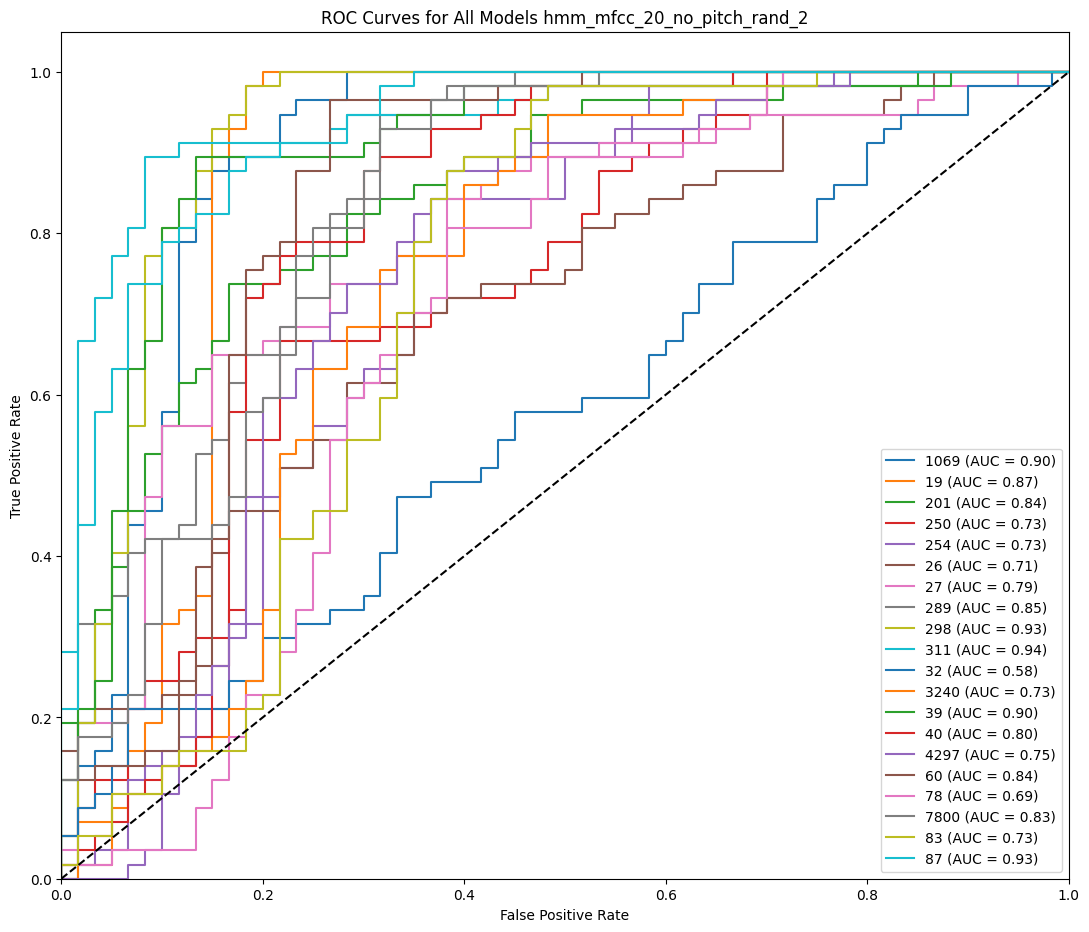

In [ ]:
save_metrics(speaker_models, test_data, output_file=f"./metrics/hmm_{features}.txt")
plot_roc_all(speaker_models, test_data, features_used=f"hmm_{features}", save_dir="./metrics")

In [21]:
max_num_samples = 300

print(f"max number of samples 87 & 201: {max_num_samples}")

train_87_f, test_87_f = partition_data(mfcc_stats_dict["87"], max_num_samples)
train_4297_f, test_4297_f = partition_data(mfcc_stats_dict["4297"], max_num_samples)
train_7800_f, test_7800_f = partition_data(mfcc_stats_dict["7800"], max_num_samples)

train_201_m, test_201_m = partition_data(mfcc_stats_dict["201"], max_num_samples)
train_311_m, test_311_m = partition_data(mfcc_stats_dict["311"], max_num_samples)
train_3240_m, test_3240_m = partition_data(mfcc_stats_dict["3240"], max_num_samples)

speaker_87_model_f = train_hmm(train_87_f)
speaker_4297_model_f = train_hmm(train_4297_f)
speaker_7800_model_f = train_hmm(train_7800_f)

speaker_201_model_m = train_hmm(train_201_m)
speaker_311_model_m = train_hmm(train_311_m)
speaker_3240_model_m = train_hmm(train_3240_m)

speaker_models = {"87_f"   : speaker_87_model_f,
                  "4297_f" : speaker_4297_model_f,
                  "7800_f" : speaker_7800_model_f,
                  "201_m"  : speaker_201_model_m,
                  "311_m"  : speaker_311_model_m,
                  "3240_m" : speaker_3240_model_m
                  }

print(type(speaker_models["87_f"]))

test_data = {"87_f"   : test_87_f,
             "4297_f" : test_4297_f,
             "7800_f" : test_7800_f,
             "201_m"  : test_201_m,
             "311_m"  : test_311_m,
             "3240_m" : test_3240_m
             }

max number of samples 87 & 201: 300
<class 'hmmlearn.hmm.GaussianHMM'>


In [79]:
save_metrics(speaker_models, test_data, output_file=f"./metrics/hmm/{features}.txt")

samples per class: 12
samples per class: 12
samples per class: 12
samples per class: 12
samples per class: 12
samples per class: 12


{'87_f': {'threshold': np.float64(-309.4735915563927),
  'matrix': [[28, 32], [9, 51]],
  'accuracy': 0.6583333333333333,
  'precision': np.float64(0.6144578313253012),
  'recall': np.float64(0.85),
  'f1': np.float64(0.7132867132867133),
  'roc_auc': np.float64(0.8325)},
 '4297_f': {'threshold': np.float64(-321.75783006807126),
  'matrix': [[43, 17], [5, 55]],
  'accuracy': 0.8166666666666667,
  'precision': np.float64(0.7638888888888888),
  'recall': np.float64(0.9166666666666666),
  'f1': np.float64(0.8333333333333334),
  'roc_auc': np.float64(0.8961111111111111)},
 '7800_f': {'threshold': np.float64(-301.30258077153877),
  'matrix': [[41, 19], [2, 58]],
  'accuracy': 0.825,
  'precision': np.float64(0.7532467532467533),
  'recall': np.float64(0.9666666666666667),
  'f1': np.float64(0.8467153284671532),
  'roc_auc': np.float64(0.9152777777777779)},
 '201_m': {'threshold': np.float64(-344.79261672703365),
  'matrix': [[40, 20], [27, 33]],
  'accuracy': 0.6083333333333333,
  'precisio

samples per class: 12
samples per class: 12
samples per class: 12
samples per class: 12
samples per class: 12
samples per class: 12


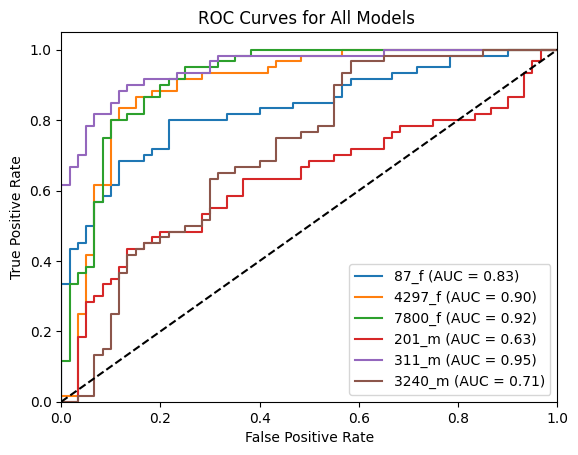

In [80]:
plot_roc_all(speaker_models, test_data, features_used="", save_dir=None)

In [69]:

with open(f"../../data/extracted_features_v2/seperate/features_19.pickle", "rb") as file:
   mfcc_stats_dict_19 = pickle.load(file)

with open(f"../../data/extracted_features_v2/seperate/features_250.pickle", "rb") as file:
   mfcc_stats_dict_26 = pickle.load(file)

max_num_samples = 300
train_19_f, test_19_f = partition_data(mfcc_stats_dict_19, max_num_samples, split=.8)
train_26_m, test_26_m = partition_data(mfcc_stats_dict_26, max_num_samples, split=.8)

print(len(train_19_f),len(test_19_f))
print(len(train_26_m),len(test_26_m))

speaker_19_model_f = train_hmm(train_19_f)
speaker_26_model_m = train_hmm(train_26_m)


speaker_models = {"19_f"   : speaker_19_model_f,
                  "26_m" : speaker_26_model_m
                 }  
test_data = {"19_f"   : test_19_f,
             "26_m" : test_26_m
             }

save_metrics(speaker_models, test_data)

240 60
240 60
samples per class: 60
samples per class: 60


{'19_f': {'threshold': np.float64(-504.2864626197034),
  'matrix': [[30, 30], [35, 25]],
  'accuracy': 0.4583333333333333,
  'precision': np.float64(0.45454545454545453),
  'recall': np.float64(0.4166666666666667),
  'f1': np.float64(0.43478260869565216),
  'roc_auc': np.float64(0.48305555555555557)},
 '26_m': {'threshold': np.float64(-433.74752902603876),
  'matrix': [[25, 35], [21, 39]],
  'accuracy': 0.5333333333333333,
  'precision': np.float64(0.527027027027027),
  'recall': np.float64(0.65),
  'f1': np.float64(0.582089552238806),
  'roc_auc': np.float64(0.6775)}}

In [31]:
import random

def generate_unique_random_numbers(n, x, seed=42):
    if n > x + 1:
        raise ValueError("Cannot generate more unique numbers than the specified range.")
    
    random.seed(seed)  # Set the seed for reproducibility
    return random.sample(range(0, x + 1), n)

# Example usage
numbers = generate_unique_random_numbers(5, 20)  # Generates 5 unique numbers between 0 and 20
print(numbers)

[20, 3, 0, 8, 7]


In [12]:
with open(r"C:\Computer Science Programs\Fall_2024\EE502_BioMed\project\data\extracted_features_v2\seperate\features_20_19.pickle") as file:
    test_dict = pickle.load(file)

print(test_dict['19'])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte